# Natural Language Processing: Kaggle's Tweet Disaster competition

This project aims to develop abilities in NLP problems. Here, the objecive is to predict the occurance of real disasters through the words found in tweets from several places.

### Data importing and first infomations

- **id** - a unique identifier for each tweet
- **text** - the text of the tweet
- **location** - the location the tweet was sent from (may be blank)
- **keyword** - a particular keyword from the tweet (may be blank)
- **target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [178]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
train_data = pd.read_csv('train.csv')
test_data =  pd.read_csv('test.csv')

In [52]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [53]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Text(0.5, 1.0, 'Test set')

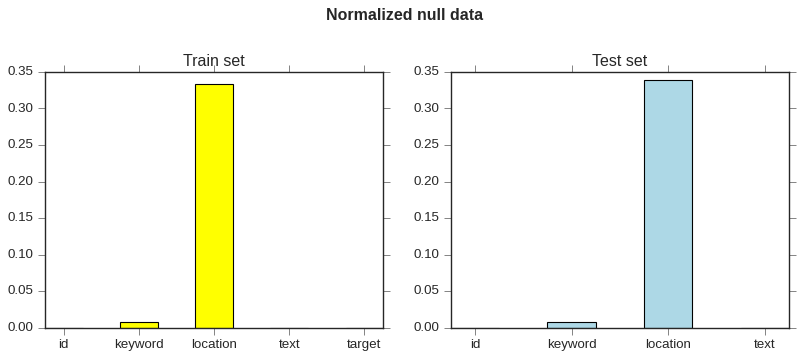

In [105]:
# Checking the amount of null information
trainNull = train_data.isnull().sum()
trainNull_percent = round(trainNull/train_data.shape[0], 3)

testNull = test_data.isnull().sum()
testNull_percent = round(testNull/test_data.shape[0], 3)

labels_train = trainNull.index
labels_test = testNull.index
width = 0.5

# Bar plot
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Normalized null data', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1.bar(labels_train, trainNull_percent, width, color='yellow')
ax1.set_title('Train set')
ax2.bar(labels_test, testNull_percent, width, color='lightblue')
ax2.set_title('Test set')

<AxesSubplot:>

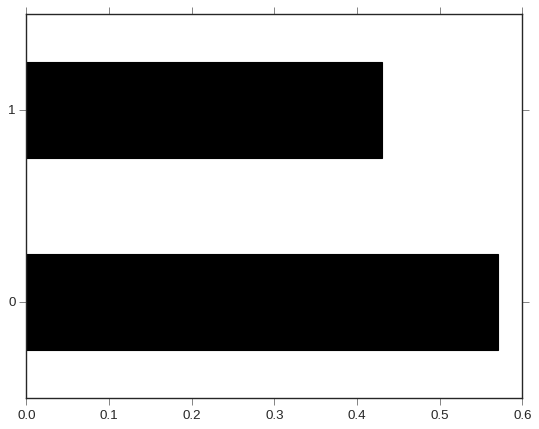

In [109]:
#Checking the balance between target classes
#(1 = real disaster, 0 = no disaster)

train_data['target'].value_counts(normalize=True).plot.barh(color='black')

Text(0.5, 1.0, 'Test set')

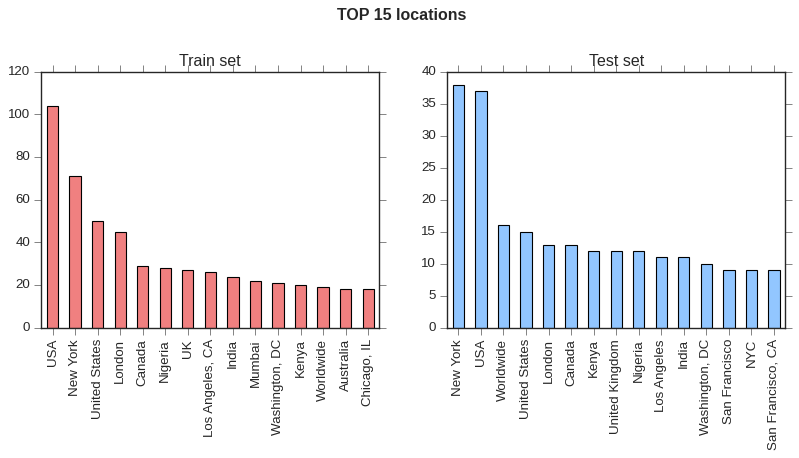

In [154]:
fig2,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig2.suptitle('TOP 15 locations', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1 = train_data['location'].value_counts()[:15].plot.bar(ax=ax1, color='lightcoral')
ax1.set_title('Train set')
ax2 = test_data['location'].value_counts()[:15].plot.bar(ax=ax2)
ax2.set_title('Test set')

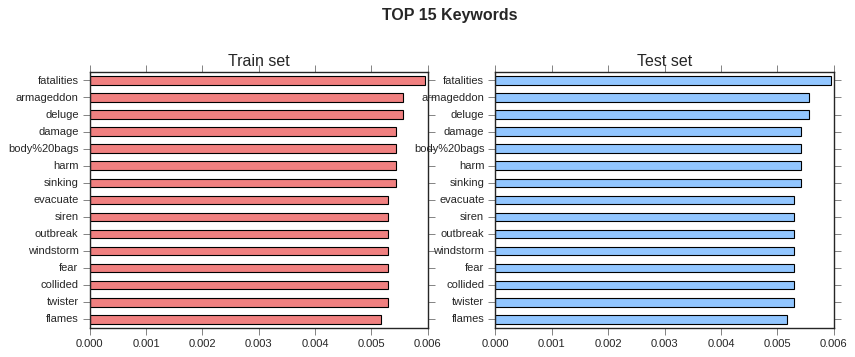

In [169]:
fig2,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig2.suptitle('TOP 15 Keywords', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')


ax1 = train_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 color='lightcoral',
                                                                                 fontsize=10,
                                                                                 title='Train set',
                                                                                 ax=ax1)

ax2 = train_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 fontsize=10,
                                                                                 title='Test set',
                                                                                 ax=ax2)

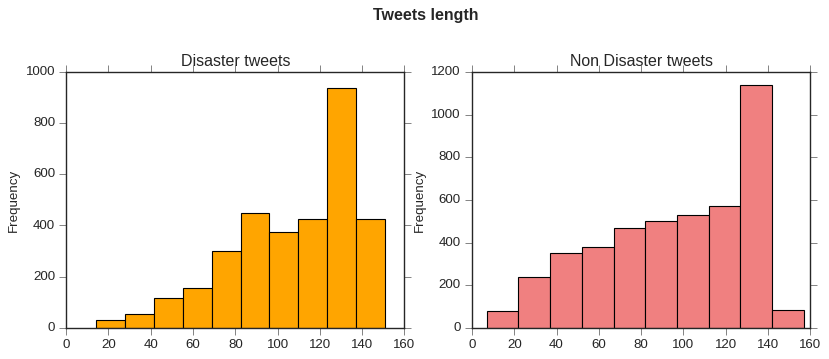

In [189]:
fig3,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig3.suptitle('Tweets length', y=1.1, weight='bold', size='large')

ax1 = train_data.query("target==1")["text"].str.len().plot(kind="hist",
                                                           color="orange",
                                                           title="Disaster tweets",
                                                           ax=ax1)

ax2 = train_data.query("target==0")["text"].str.len().plot(kind="hist",
                                                           color="lightcoral",
                                                           title="Non Disaster tweets",
                                                           ax=ax2)

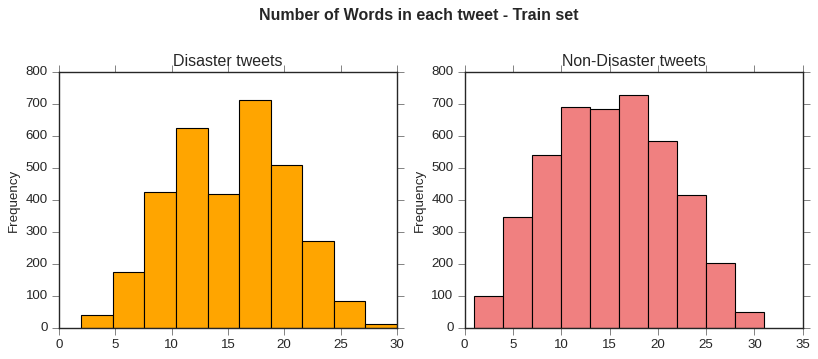

In [192]:
fig4,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig4.suptitle('Number of Words in each tweet - Train set', y=1.1, weight='bold', size='large')

ax1 = train_data.query("target==1").text.map(lambda x: len(x.split())).plot(kind="hist",
                                                                            color="orange",
                                                                            title="Disaster tweets",
                                                                            ax=ax1)

ax2 = train_data.query("target==0").text.map(lambda x: len(x.split())).plot(kind="hist",
                                                                            color="lightcoral",
                                                                            title="Non-Disaster tweets",
                                                                            ax=ax2)

/home/raissa/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/raissa/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


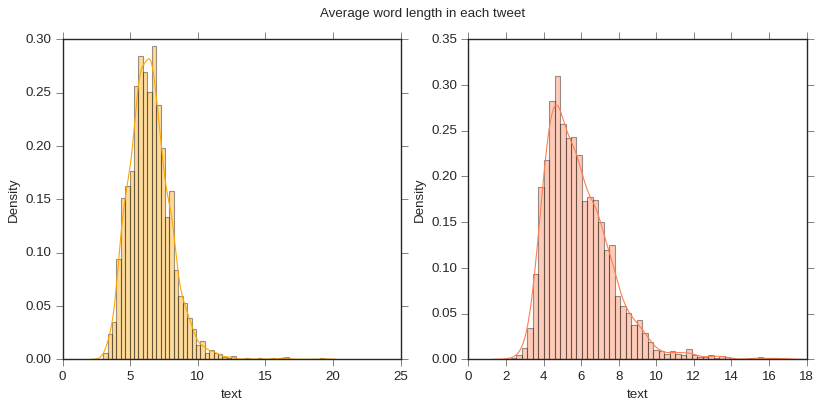

In [198]:
fig5, axes = plt.subplots(1, 2, figsize=(12,5))
fig5.suptitle('Average word length in each tweet')

each_words_len = train_data.query("target==1").text.str.split().map(lambda x: [len(i) for i in x])
sns.distplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=axes[0], color="orange");

each_words_len = train_data.query("target==0").text.str.split().map(lambda x: [len(i) for i in x])
sns.distplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=axes[1], color='coral');

In [233]:
import string
from nltk.corpus import stopwords
from collections import defaultdict
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [208]:
def plot_punctuations(df, target):
    
    punctations_dict = defaultdict(int)
    
    for idx, text in df[df["target"]==target].text.iteritems():
        for token in text.split():
            if token in string.punctuation:
                punctations_dict[token] +=1   

    return dict(sorted(punctations_dict.items(), key=lambda x: x[1], reverse=True))


dt_punctuations = plot_punctuations(train_data, target=1)
ndt_punctuations = plot_punctuations(train_data, target=0)

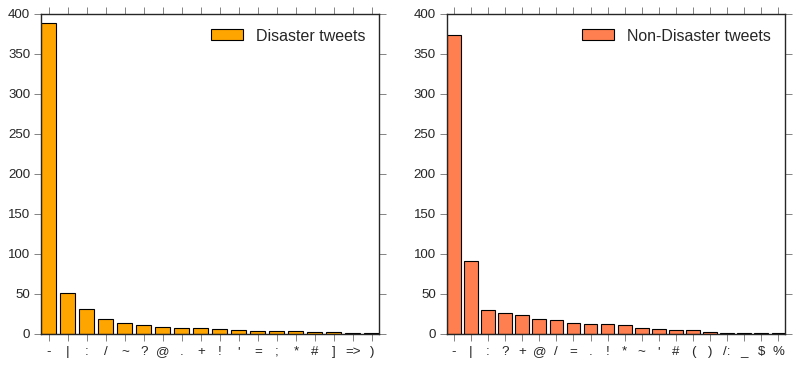

In [231]:
fig5, axes = plt.subplots(1, 2, figsize=(12,5))

x1, y1 = zip(*dt_punctuations.items())
axes[0].bar(x1, y1, color="orange", label="Disaster tweets")
axes[0].legend()


x2, y2 = zip(*ndt_punctuations.items())
axes[1].bar(x2, y2, color="coral", label="Non-Disaster tweets")
axes[1].legend()

In [234]:
stop_words= set(stopwords.words("english"))

# updating the stopwords considering the 
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color= "black", 
               colormap="Paired",
               max_font_size=150)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/raissa/nltk_data'
    - '/home/raissa/anaconda3/nltk_data'
    - '/home/raissa/anaconda3/share/nltk_data'
    - '/home/raissa/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
